In [77]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

from numpy.random import default_rng
rng = default_rng()

In [73]:
@jit(nopython=True)
def get_b(t_history, history, tau, N=100):
    curr_time = t_history[N-1]
    norm=0
    B = 0
    for n in range(1,N):
        tmp = history[N-n]
        dt = t_history[N-n] - curr_time
        weight = np.exp(dt/tau)
        norm += weight
        tmp *= weight
        B += tmp
    
    B *= 1.0/norm
    return B

@jit(nopython=True)
def get_bdot(t_history, history, tau, N=100):
    curr_time = t_history[N-1]
    norm=0
    dBdt = 0
    for n in range(0,N-1):
        tmp = history[N-n]
        dt = t_history[N-n] - curr_time
        weight = np.exp(dt/tau)
        norm += weight
        tmp *= weight
        dBdt += tmp
        
    curr_time = t_history[N-2]
    norm=0
    B = 0
    for n in range(1,N-2):
        tmp = history[N-n]
        dt = t_history[N-n] - curr_time
        weight = np.exp(dt/tau)
        tmp *= weight
        dBdt -= tmp
    
    return dBdt

Text(0.5, 0, 'time')

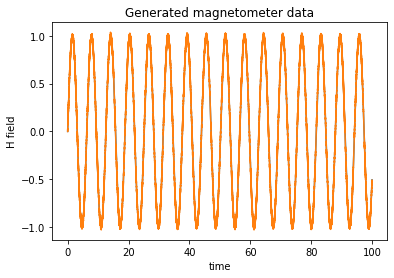

In [96]:
BUFFER_LEN=50000

T_clean = np.linspace(0,100,BUFFER_LEN)
Y_clean = np.sin(T_clean)

t_stdev = 1e-9
y_stdev = 0.01

T=T_clean+rng.standard_normal(BUFFER_LEN)*t_stdev
T.sort()
Y=np.sin(T) +rng.standard_normal(BUFFER_LEN)*y_stdev
true_dY = np.cos(T)
plt.plot(T_clean,Y_clean)
plt.plot(T,Y)
plt.title('Generated magnetometer data')
plt.ylabel('H field')
plt.xlabel('time')

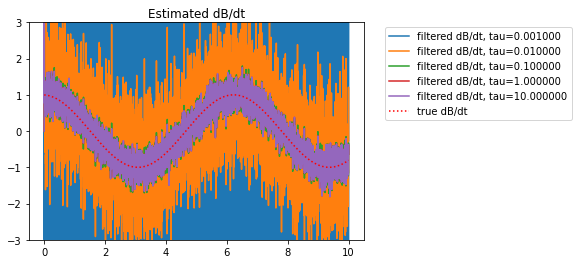

In [103]:
domain = 5000
num_for_samp=30

dB = np.zeros(domain)
dB2 = np.zeros(domain)
B = np.zeros(domain)
cY = np.zeros(domain)


plt.title('Estimated dB/dt')
          
for filter_tau in [0.001,0.01,0.1,1,10]:

    for i in range(1,domain):
        samp_Y = Y[i:i+num_for_samp]
        cY[i] = Y[i+num_for_samp-1]
        samp_T = T[i:i+num_for_samp]
        B[i] = get_b(samp_T,samp_Y, tau=filter_tau,N=num_for_samp)
        dB[i] = (B[i]-B[i-1])/(samp_T[num_for_samp-1]-samp_T[num_for_samp-2])

    plt.plot(T[:domain],dB, label="filtered dB/dt, tau=%f"%filter_tau)
              
plt.plot(T_clean[:domain],true_dY[num_for_samp:domain+num_for_samp],'r:',label="true dB/dt")
plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.05, 1))